In [1]:
import os
import sys
sys.path.append(os.path.join('..', '..'))

from scripts.data_loaders.TIMIT import TIMITDataset
from scripts.data_loaders.EpaDB import EpaDBDataset
from scripts.data_loaders.PSST import PSSTDataset
from scripts.data_loaders.SpeechOcean import SpeechOceanDataset
from scripts.data_loaders.ISLE import ISLEDataset

from scripts.ipa_transcription.wav2vec2 import transcribe_batch, clear_cache, load_model
from scripts.eval.evaluate import evaluate
from scripts.core.ipa import remove_length_diacritics, remove_tones_and_stress
from scripts.core.audio import TARGET_SAMPLE_RATE

import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import namedtuple

from IPython.display import clear_output
clear_output()

In [2]:
TestSet = namedtuple('TestSet', ['name', 'data'])

testsets = [
    TestSet('TIMIT', TIMITDataset(split='test')),
    TestSet('EpaDB', EpaDBDataset(split='test')),
    TestSet('PSST', PSSTDataset(split='test', force_offline=True)),
    TestSet('SpeechOcean', SpeechOceanDataset(split='test')),
    TestSet('ISLE', ISLEDataset(split="all"))
]

psstdata INFO: Loaded data version local at /Users/alex/Desktop/CS/Startups/Koel/ML/notebooks/Eval/../../scripts/data_loaders/../../.data/psst-data


In [3]:
Model = namedtuple('Model', ['name', 'model_id'])

models = [
    Model('Facebook 53', "facebook/wav2vec2-xlsr-53-espeak-cv-ft"),
    Model('Facebook 53 Condensed', os.path.join("..", "..", "models", "facebook53_condensed")),
    Model('Facebook 60', "facebook/wav2vec2-lv-60-espeak-cv-ft"),
    Model('Koel Labs B0', "KoelLabs/xlsr-timit-b0"),
    # Model('Ginic', "ginic/data_seed_4_wav2vec2-large-xlsr-buckeye-ipa"),
    Model('Ginic', "/Users/alex/Desktop/CS/Startups/Koel/ML/models/models--ginic--wav2vec-large-xlsr-en-ipa/snapshots/da5b75f61782657f7e69353e1832962cbd9272a5"),
    Model('Speech31', "speech31/XLS-R-300m-english-ipa"),
    Model('Vitouphy', "vitouphy/wav2vec2-xls-r-300m-timit-phoneme"),
    # Model('Taguchi', "ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ipa-plus-2000"),
    Model('Taguchi', "/Users/alex/Desktop/CS/Startups/Koel/ML/models/models--ctaguchi--wav2vec2-large-xlsr-japlmthufielta-ipa-plus-2000/snapshots/92cfe1211b01f9026ffca191c84ce06161926f45"),
    Model('Rubino', "mrrubino/wav2vec2-large-xlsr-53-l2-arctic-phoneme"),
    Model('Koel Labs English 01', 'KoelLabs/xlsr-english-01'),
]

In [4]:
total_audio_hours = 0
total_audio_minutes_by_dataset = {}
for dataset_name, dataset in testsets:
    total_audio_minutes_by_dataset[dataset_name] = 0
    for s in dataset:
        total_audio_hours += len(s[1]) / TARGET_SAMPLE_RATE / 60 / 60
        total_audio_minutes_by_dataset[dataset_name] += len(s[1]) / TARGET_SAMPLE_RATE / 60
print("Total audio hours:", total_audio_hours)
print("Total audio minutes by dataset:", total_audio_minutes_by_dataset)

Total audio hours: 15.361804791666534
Total audio minutes by dataset: {'TIMIT': 81.57751979166659, 'EpaDB': 66.38319583333303, 'PSST': 30.46739687500001, 'SpeechOcean': 159.83154999999996, 'ISLE': 583.448625000003}


In [5]:
OUTPUT_PATH = os.path.join('..', '..', '.data', 'ipa_predictions.csv')

if os.path.exists(OUTPUT_PATH):
    output_df = pd.read_csv(OUTPUT_PATH)
    output_df = output_df[output_df['model_name'].isin([x[0] for x in models])]
else:
    output_df = pd.DataFrame(columns=[
        'dataset',
        'model_name',
        'ground_truth',
        "prediction"
    ])

In [6]:
BATCH_SIZE = 4
for model_name, model_id in models:
    clear_cache()
    model, processor = None, None
    for dataset_name, dataset in testsets:
        print(model_name, dataset_name, '...', end=" ")

        # if dataset and model combo already in df, skip
        if len(output_df) > 0 and ((output_df['dataset'] == dataset_name) & (output_df['model_name'] == model_name)).any():
            print("already done")
            continue

        if model is None or processor is None:
            model, processor = load_model(model_id)

        amount = len(dataset)
        for i in range(0, amount, BATCH_SIZE):
            clear_cache()
            size = min(BATCH_SIZE, amount - i)
            transcriptions = transcribe_batch(dataset[i:i+size], model, processor)
            for j in range(size):
                output_df = pd.concat([output_df, pd.DataFrame([[
                    dataset_name,
                    model_name,
                    dataset[i + j][0],
                    transcriptions[j]
                ]], columns=output_df.columns)])

        output_df.to_csv(OUTPUT_PATH, index=False)
        print("done")

Facebook 53 TIMIT ... already done
Facebook 53 EpaDB ... already done
Facebook 53 PSST ... already done
Facebook 53 SpeechOcean ... already done
Facebook 53 ISLE ... already done
Facebook 53 Condensed TIMIT ... already done
Facebook 53 Condensed EpaDB ... already done
Facebook 53 Condensed PSST ... already done
Facebook 53 Condensed SpeechOcean ... already done
Facebook 53 Condensed ISLE ... already done
Facebook 60 TIMIT ... already done
Facebook 60 EpaDB ... already done
Facebook 60 PSST ... already done
Facebook 60 SpeechOcean ... already done
Facebook 60 ISLE ... already done
Koel Labs B0 TIMIT ... already done
Koel Labs B0 EpaDB ... already done
Koel Labs B0 PSST ... already done
Koel Labs B0 SpeechOcean ... already done
Koel Labs B0 ISLE ... already done
Ginic TIMIT ... already done
Ginic EpaDB ... already done
Ginic PSST ... already done
Ginic SpeechOcean ... already done
Ginic ISLE ... already done
Speech31 TIMIT ... already done
Speech31 EpaDB ... already done
Speech31 PSST ..

In [7]:
# drop ambiguous th sounds in speech ocean
output_df = output_df[(output_df['dataset'] != 'SpeechOcean') | ~output_df['ground_truth'].apply(lambda x: 'ð' in x or 'θ' in x)]

In [8]:
# Inspect failed rows
output_df[output_df['prediction'].isna()]

,dataset,model_name,ground_truth,prediction
19388,SpeechOcean,Koel Labs B0,ʃimʌstbimeɪdtʌsteɪ,NaN
23493,PSST,Ginic,sksk,NaN
24415,SpeechOcean,Ginic,hɪʌɪzmɛˈɝɪsʃuz,NaN
25472,SpeechOcean,Ginic,ʃimʌstbimeɪdtʌsteɪ,NaN
37640,SpeechOcean,Vitouphy,ʃimʌstbimeɪdtʌsteɪ,NaN
53362,PSST,Facebook 53 Condensed,aɪdoʊnoʊ,NaN
53926,PSST,Facebook 53 Condensed,hɔɹs,NaN
462373,SpeechOcean,Koel Labs English 01,ʃimʌstbimeɪdtʌsteɪ,NaN


In [9]:
# drop failed rows
output_df.dropna(inplace=True)

In [10]:
def remove_bad_model_vocab(ipa):
    ipa = ''.join(c for c in ipa if not c.isdigit()).lower().replace("#", "").replace("*", "") # .replace("ɔ̇", "ɔ")
    ipa = remove_length_diacritics(remove_tones_and_stress(ipa)).replace(".", "").replace('̪', '').replace("[", "")
    return ipa.replace("̇", "")

In [11]:
output_df[["per", "fer"]] = output_df.parallel_apply(lambda x: pd.Series(evaluate(remove_bad_model_vocab(x['ground_truth']), remove_bad_model_vocab(x['prediction']), simplify=False)), axis=1) # type: ignore

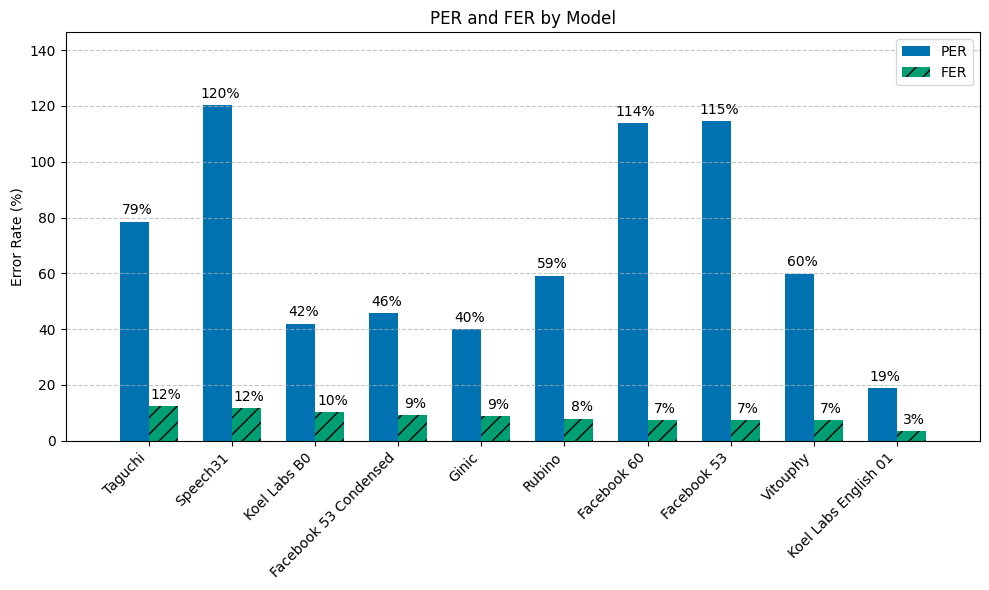

In [12]:
# plot per and fer by model as bar chart with two bars per model (one for per and one for fer)
plt.style.use('seaborn-v0_8-colorblind')
# models = ['Facebook 53', 'Facebook 60', 'Koel Labs B0', 'Vitouphy']
models = output_df['model_name'].unique()
agg_df = output_df[output_df["model_name"].isin(models)].groupby(['dataset', 'model_name'])[["per", "fer"]].mean().groupby('model_name').mean().sort_values(by="fer", ascending=False).reset_index()
x = np.arange(len(agg_df["model_name"]))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, 100*agg_df["per"], width, label='PER')
bars2 = ax.bar(x + width/2, 100*agg_df["fer"], width, label='FER', hatch="//")

# Add labels and title
ax.set_ylabel('Error Rate (%)')
ax.set_title('PER and FER by Model')
ax.set_xticks(x)
ax.set_xticklabels(agg_df["model_name"], rotation=45, ha="right")
ax.set_xlim((min(x) - 1, max(x) + 1))
ax.set_ylim(bottom=ax.get_ylim()[0], top=ax.get_ylim()[1] + 20)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.legend()

# Optionally add value labels on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.0f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(2, 3),  # (horizontal offset, vertical offset)
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

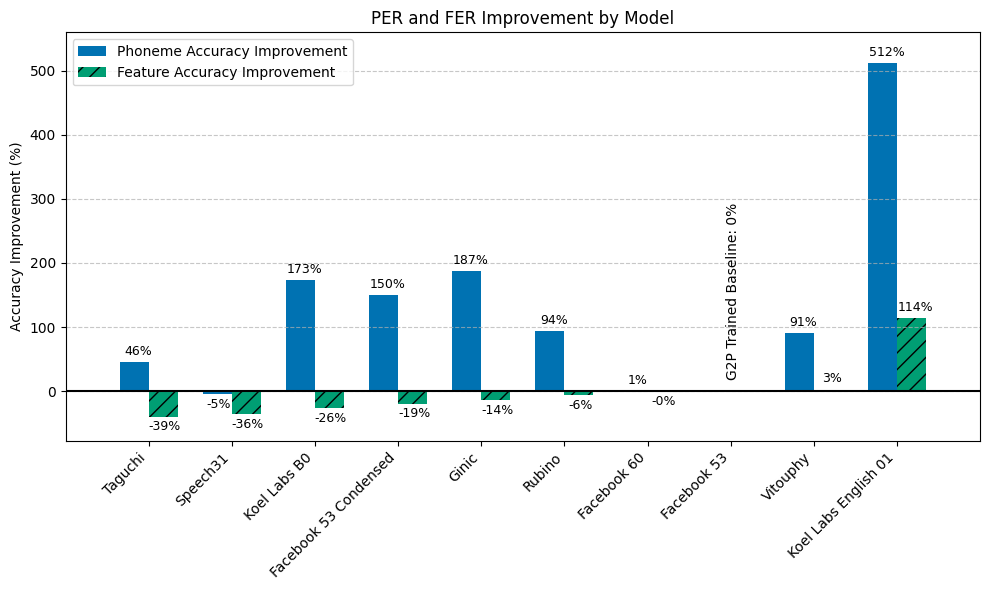

In [13]:
# plot per and fer by model as bar chart with two bars per model (one for per and one for fer)
# models = ['Facebook 53', 'Facebook 60', 'Koel Labs B0', 'Vitouphy']
models = output_df['model_name'].unique()
agg_df = output_df[output_df["model_name"].isin(models)].groupby(['dataset', 'model_name'])[["per", "fer"]].mean().groupby('model_name').mean().sort_values(by="fer", ascending=False).reset_index()
x = np.arange(len(agg_df["model_name"]))  # label locations
width = 0.35  # bar width

ANCHOR = 'Facebook 53'
anchor_per = agg_df['per'][agg_df["model_name"] == ANCHOR].iloc[0]
anchor_fer = agg_df['fer'][agg_df["model_name"] == ANCHOR].iloc[0]

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, 100 * anchor_per / agg_df["per"] - 100, width, label='Phoneme Accuracy Improvement')
bars2 = ax.bar(x + width/2, 100 * anchor_fer / agg_df["fer"] - 100, width, label='Feature Accuracy Improvement', hatch="//")

# Add labels and title
ax.set_ylabel('Accuracy Improvement (%)')
ax.set_title('PER and FER Improvement by Model')
ax.set_xticks(x)
ax.set_xticklabels(agg_df["model_name"], rotation=45, ha="right")
ax.set_xlim((min(x) - 1, max(x) + 1))
ax.set_ylim(bottom=ax.get_ylim()[0] - 10, top=ax.get_ylim()[1] + 20)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.legend(loc='upper left')

# Optionally add value labels on top of bars
for bar in bars1 + bars2:
    if list(agg_df["model_name"]).index(ANCHOR) == int(bar.get_x() + 0.5):
        continue
    height = bar.get_height()
    ax.annotate(f'{height:.0f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(3 if height >= 0 else 1, 3 if height >= 0 else -12),  # (horizontal offset, vertical offset)
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

ax.annotate("G2P Trained Baseline: 0%",
                xy=(list(agg_df["model_name"]).index(ANCHOR) - 0.05, 0),
                xytext=(len(f'{height:.0f}%')+1, 8),  # (horizontal offset, vertical offset)
                textcoords="offset points",
                ha='center', va='bottom', rotation=90)

plt.axhline(y=0, color='black', linestyle='-')

plt.tight_layout()
plt.show()

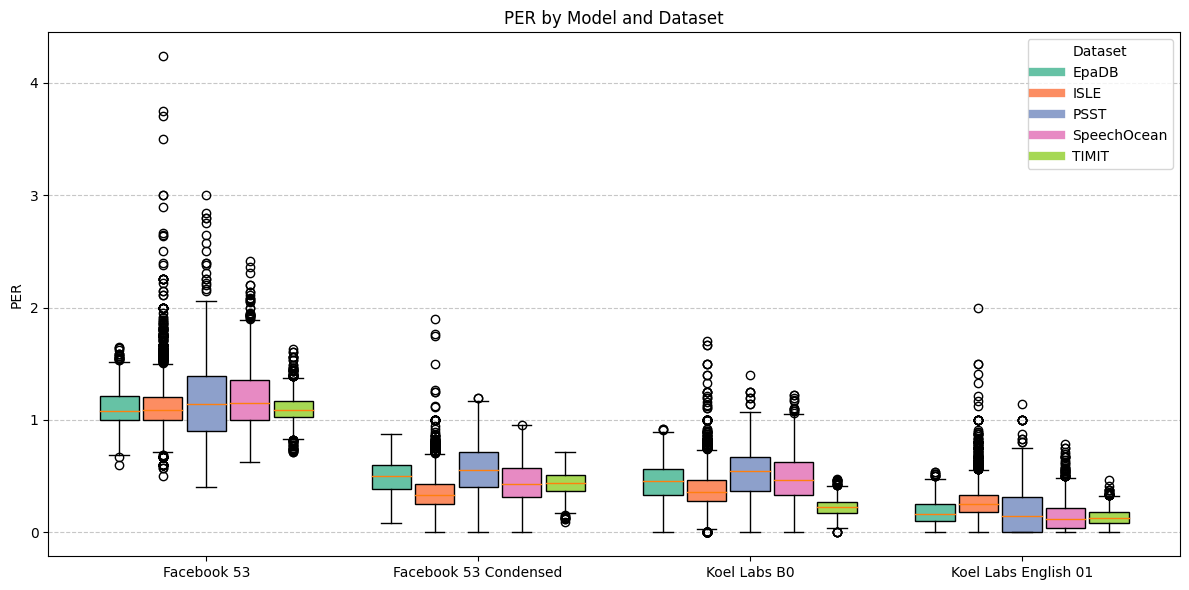

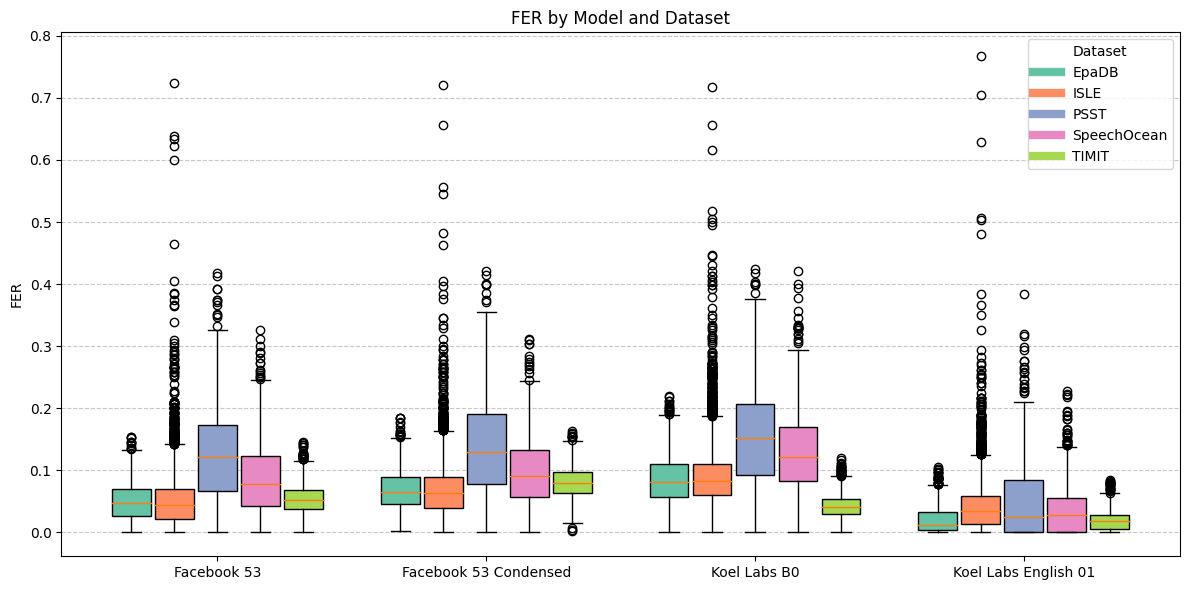

In [14]:
# two box plots (one for per and one for fer) for each model and dataset combo
models = ['Facebook 53', 'Facebook 53 Condensed', 'Koel Labs B0', 'Koel Labs English 01']
# models = sorted(output_df['model_name'].unique())
datasets = sorted(output_df['dataset'].unique())
plt.style.use('default')
colors = sns.color_palette("Set2", len(datasets))

# Define helper function to create grouped boxplots
def plot_grouped_boxplots(metric: str, title: str):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    positions = []
    labels = []
    data = []
    current_pos = 0
    width = 4 / len(datasets)  # width per box within each group

    for model in models:
        for i, dataset in enumerate(datasets):
            subset = output_df[(output_df['model_name'] == model) & (output_df['dataset'] == dataset)]
            if not subset.empty:
                values = subset[metric].values
                for _ in range(3): # eliminate top 3 outliers
                    values[values.argmax()] = values.mean()
                data.append(values)
                pos = current_pos + i * width
                positions.append(pos)
                labels.append(model if i == len(datasets) // 2 else "")  # Label model only once
            else:
                print("Empty", model, dataset)
        current_pos += width * len(datasets) + 1  # Add spacing between models

    # Flatten and plot each box individually with appropriate color
    bp = ax.boxplot(data, positions=positions, widths=width*0.9, patch_artist=True, manage_ticks=False)

    # Color boxes
    for i, box in enumerate(bp['boxes']):
        dataset_index = i % len(datasets)
        box.set(facecolor=colors[dataset_index])

    # Legend
    handles = [plt.Line2D([0], [0], color=color, lw=6) for color in colors] # type: ignore
    ax.legend(handles, datasets, title="Dataset")

    ax.set_title(title)
    ax.set_ylabel(metric.upper())
    ax.set_xticks(
        [np.mean(positions[i*len(datasets):(i+1)*len(datasets)]) for i in range(len(models))]
    )
    ax.set_xticklabels(models, rotation=0, ha='center')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot both PER and FER
plot_grouped_boxplots("per", "PER by Model and Dataset")
plot_grouped_boxplots("fer", "FER by Model and Dataset")

In [15]:
output_df.groupby(['model_name'])[['per', 'fer']].mean()

,per,fer
model_name,,
Facebook 53,1.122765,0.058586
Facebook 53 Condensed,0.394513,0.076793
Facebook 60,1.114545,0.055159
Ginic,0.363558,0.072162
Koel Labs B0,0.387079,0.090104
Koel Labs English 01,0.229144,0.037132
Rubino,0.539654,0.057043
Speech31,1.164565,0.093657
Taguchi,0.738910,0.104752


In [16]:
output_df.groupby(['dataset'])[['per', 'fer']].mean()

,per,fer
dataset,,
EpaDB,0.690633,0.065151
ISLE,0.652874,0.064283
PSST,0.772955,0.138265
SpeechOcean,0.741413,0.102227
TIMIT,0.650125,0.055957


In [17]:
means_by_dataset_model_combo = output_df.groupby(['dataset', 'model_name'])[['per', 'fer']].mean()
pd.set_option('display.max_rows', len(means_by_dataset_model_combo))
means_by_dataset_model_combo

per       fer
dataset     model_name                               
EpaDB       Facebook 53            1.104416  0.051039
            Facebook 53 Condensed  0.489240  0.068878
            Facebook 60            1.108942  0.050660
            Ginic                  0.458957  0.074836
            Koel Labs B0           0.458319  0.084843
            Koel Labs English 01   0.180914  0.020794
            Rubino                 0.590655  0.051719
            Speech31               1.151722  0.101243
            Taguchi                0.746699  0.092755
            Vitouphy               0.616467  0.054741
ISLE        Facebook 53            1.118461  0.052031
            Facebook 53 Condensed  0.346358  0.068471
            Facebook 60            1.099030  0.045041
            Ginic                  0.346732  0.066469
            Koel Labs B0           0.382654  0.089657
            Koel Labs English 01   0.271496  0.042192
            Rubino                 0.516519  0.046492
            Speech31               1.147621  0.082929
            Taguchi                0.709372  0.094480
            Vitouphy               0.590497  0.055063
PSST        Facebook 53            1.201650  0.127253
            Facebook 53 Condensed  0.558067  0.141370
            Facebook 60            1.161967  0.133529
            Ginic                  0.476107  0.135401
            Koel Labs B0           0.545545  0.155605
            Koel Labs English 01   0.197176  0.053890
            Rubino                 0.778023  0.163966
            Speech31               1.311881  0.181403
            Taguchi                0.872330  0.174067
            Vitouphy               0.625692  0.116167
SpeechOcean Facebook 53            1.205865  0.087047
            Facebook 53 Condensed  0.451198  0.100089
            Facebook 60            1.214377  0.092540
            Ginic                  0.432335  0.109800
            Koel Labs B0           0.485261  0.131572
            Koel Labs English 01   0.148782  0.036859
            Rubino                 0.595878  0.082278
            Speech31               1.312497  0.142439
            Taguchi                0.866009  0.143145
            Vitouphy               0.696679  0.096178
TIMIT       Facebook 53            1.096356  0.053599
            Facebook 53 Condensed  0.443069  0.080414
            Facebook 60            1.104573  0.049492
            Ginic                  0.279218  0.046552
            Koel Labs B0           0.226349  0.042883
            Koel Labs English 01   0.137096  0.019891
            Rubino                 0.477188  0.051066
            Speech31               1.095548  0.070389
            Taguchi                0.731552  0.108278
            Vitouphy               0.464065  0.039364

In [18]:
means_by_dataset_model_combo.groupby('model_name').mean()

,per,fer
model_name,,
Facebook 53,1.145350,0.074194
Facebook 53 Condensed,0.457586,0.091844
Facebook 60,1.137778,0.074252
Ginic,0.398670,0.086612
Koel Labs B0,0.419626,0.100912
Koel Labs English 01,0.187093,0.034725
Rubino,0.591652,0.079104
Speech31,1.203854,0.115681
Taguchi,0.785192,0.122545


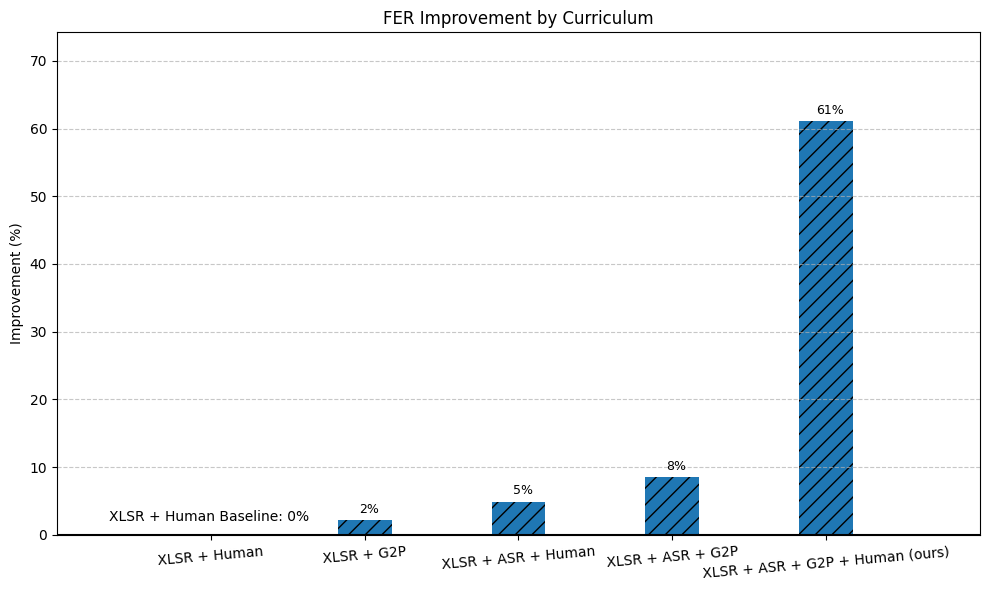

In [20]:
# plot improvement by method
model_name_to_method = {
    'Vitouphy': 'XLSR + Human',
    'Facebook 53': 'XLSR + G2P',
    'Rubino': 'XLSR + ASR + Human',
    'Facebook 60': 'XLSR + ASR + G2P',
    'Koel Labs English 01': 'XLSR + ASR + G2P + Human (ours)',
}
models = model_name_to_method.keys()
agg_df = output_df[output_df["model_name"].isin(models)].groupby(['model_name'])[["fer"]].mean().sort_values(by="fer", ascending=False).reset_index()
x = np.arange(len(agg_df["model_name"]))  # label locations
width = 0.35  # bar width

ANCHOR = 'Vitouphy'
anchor_fer = agg_df['fer'][agg_df["model_name"] == ANCHOR].iloc[0]

fig, ax = plt.subplots(figsize=(10, 6))
bars2 = ax.bar(x, 100 * anchor_fer / agg_df["fer"] - 100, width, label='FER Improvement', hatch="//")

# Add labels and title
ax.set_ylabel('Improvement (%)')
ax.set_title('FER Improvement by Curriculum')
ax.set_xticks(x)
ax.set_xticklabels([model_name_to_method[m] for m in agg_df["model_name"]], rotation=5, ha="center")
ax.set_xlim((min(x) - 1, max(x) + 1))
ax.set_ylim(top=ax.get_ylim()[1] + 10)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Optionally add value labels on top of bars
for bar in bars2:
    if list(agg_df["model_name"]).index(ANCHOR) == int(bar.get_x() + 0.5):
        continue
    height = bar.get_height()
    ax.annotate(f'{height:.0f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(3 if height >= 0 else 1, 3 if height >= 0 else -12),  # (horizontal offset, vertical offset)
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

ax.annotate("XLSR + Human Baseline: 0%",
                xy=(list(agg_df["model_name"]).index(ANCHOR) - 0.05, 0),
                xytext=(len(f'{height:.0f}%')+1, 8),  # (horizontal offset, vertical offset)
                textcoords="offset points",
                ha='center', va='bottom', rotation=0)

plt.axhline(y=0, color='black', linestyle='-')

plt.tight_layout()
plt.show()